In [1]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pyloudnorm as pyln
# https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
from scipy.signal import savgol_filter

from data.dataset import MultitrackAudioDataset
from data.dataset_utils import load_tracks, load_tracks_musdb18
from data.medleydb_split import weathervane_music, musdb18_not_in_medleydb
from models.model_scalar_v2 import MixingModelScalar2d
from models.model_scalar_v2_2s import MixingModelScalar2d2s
from inference_utils import mix_song_smooth
from evaluation import LoudnessEvaluator

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

Torch version:  1.6.0
Device:  cuda


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
seed = 321
chunk_length = 2

d = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music + musdb18_not_in_medleydb,
    chunk_length=chunk_length,
    normalize=False,
    compute_features=False
)

In [6]:
mean_loudness = d.compute_mean_loudness()

0/80: Johnny Lokke - Whisper To A Scream
-25.397791775767015
-22.879147802644447
-22.459551645982568
-22.878238221240625
-17.843798308072632
1/80: Dark Ride - Burning Bridges
-22.850757033944696
-21.532428088180733
-23.40061439536728
-25.272651983645712
-17.49071201537211
2/80: James May - Dont Let Go
-25.770289929198974
-31.437236769835387
-25.29381353316956
-25.94424392681742
-21.335074902144775
3/80: Spike Mullings - Mike's Sulking
-24.656945221841845
-24.734913914708603
-21.60642362200797
-21.70027609141081
-18.02117547234695
4/80: Johnny Lokke - Promises & Lies
-27.140726706805804
-24.035123650987906
-20.18541976925506
-21.34740731525303
-17.350484827477306
5/80: Leaf - Wicked
-28.036059534893656
-25.89031479810249
-24.15602421455438
-29.820211830693722
-21.675850868258784
6/80: StevenClark_Bounty
-24.398016482171656
-25.29714995600037
-30.73132669012224
-28.618964977359187
-11.757355932358044
7/80: SecretMountains_HighHorse
-25.071203790832442
-29.210393623053687
-31.599715453915

-26.185273908064115
-27.839747279372585
-33.184884061423396
-26.9099231177188
-12.994002085563094
64/80: Actions - South Of The Water
-23.34360157955044
-25.510104416332943
-25.302787956483744
-23.485031374836577
-18.637560095315305
65/80: BigTroubles_Phantom
-32.31873324963842
-36.49365521938367
-32.4144144363028
-29.488178075556117
-12.702740307378814
66/80: HezekiahJones_BorrowedHeart
-30.210517398499313
-34.62807828423086
-33.94094932948577
-32.16253328488641
-19.231236662158736
67/80: Voelund - Comfort Lives In Belief
-27.8422418751236
-27.097321972094516
-22.076455025636122
-22.616818049988595
-18.81983914712841
68/80: Skelpolu - Human Mistakes
-21.627506932837104
-24.431673998929032
-24.473527056149564
-25.18449973443859
-18.30930659318819
69/80: Lushlife_ToynbeeSuite
-24.011878222564757
-26.647760112126498
-31.884996703392464
-26.599422555629044
-13.54846731059092
70/80: FacesOnFilm_WaitingForGa
-33.44717984572276
-41.40963458554232
-35.966991334855976
-31.986201136520137
-14.2

In [7]:
mean_loudness

{'bass': -26.71984875608519,
 'drums': -27.45401316646605,
 'vocals': -24.75661023584791,
 'other': -25.577358074924327,
 'mix': -17.953858913937655}

In [8]:
model = MixingModelScalar2d2s().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

990468 trainable parameters


In [10]:
# weights = './saved_models/scalar2d_scalar2d_6669.pt'
# weights = './saved_models/training-ignite-unnorm-70-epochs-135.08-val-loss-fter-bugfix/scalar2d_scalar2d_5658.pt'
weights = './saved_models/from_server/training-ignite-+musdb-unnorm-28-epochs-124.7-val-loss/scalar2d_scalar2d_3472.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [20]:
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
# song_name = 'Meaxic_YouListen'
song_name = 'AimeeNorwich_Child'
loaded_tracks = load_tracks(base_dir, song_name)

# base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MUSDB18HQ/test/'
# song_name = 'Triviul feat. The Fiend - Widow'
# loaded_tracks = load_tracks_musdb18(base_dir, song_name)

# evaluate_loudness(loaded_tracks)

---
### Mix MedleyDB

In [21]:
# random_gains = np.random.uniform(0.1, 2.5, size=4)
# print(random_gains)

# for i, track in enumerate(loaded_tracks):
#     if track != 'mix':
#         loaded_tracks[track] = random_gains[i] * loaded_tracks[track]

mixed_tracks, raw_gains, smooth_gains = mix_song_smooth(d, model, loaded_tracks, chunk_length=chunk_length)

# mix = librosa.util.normalize(mixed_tracks['mix'], axis=1)
mix = mixed_tracks['mix']

sf.write('./results/{}_mixed.wav'.format(song_name), mix.T, 44100)

---
### Mix MUSDB18

In [17]:
# randomly fuck up gains before the inference
# random_gains = np.random.uniform(0.5, 2.0, size=4)
# print(random_gains)

# for i, track in enumerate(loaded_tracks):
#     if track != 'mix':
#         loaded_tracks[track] = random_gains[i] * loaded_tracks[track]

# loudness = evaluate_loudness(loaded_tracks)
# print(loudness)
# print('-' * 80)

mixed_tracks, raw_gains, smooth_gains = mix_song_smooth(d, model, loaded_tracks, chunk_length=chunk_length)

# loudness = evaluate_loudness(mixed_tracks)
# print(loudness)

mix = librosa.util.normalize(mixed_tracks['mix'], axis=1)
# mix = mixed_tracks['mix']

sf.write('./results/{}_mixed.wav'.format(song_name), mix.T, 44100)

In [22]:
# ---------------------------------------------------------------------
# producing a sum track for comparison
tracks = ['bass', 'drums', 'vocals', 'other']
coeffs = [1.0, 1.0, 1.0, 1.0]

sum_track = np.zeros_like(loaded_tracks['mix'])
for i, track in enumerate(tracks):
    sum_track += coeffs[i] * loaded_tracks[track]

sum_track = librosa.util.normalize(sum_track, axis=1)
sf.write('./results/{}_sum.wav'.format(song_name), sum_track.T, 44100)

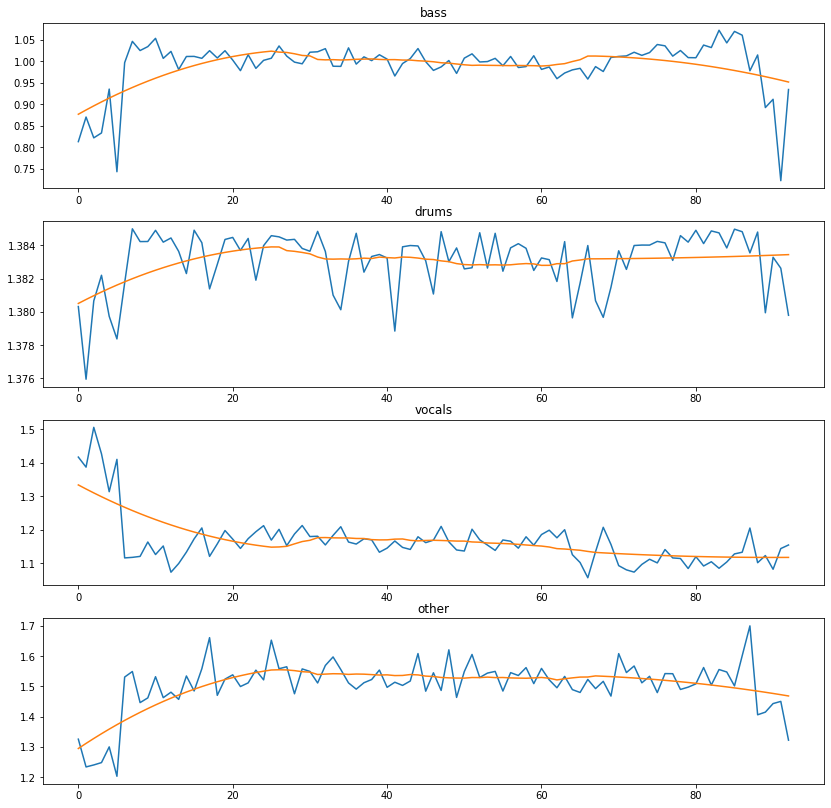

In [23]:
plt.figure(figsize=(14, 14))

for i, track in enumerate(raw_gains):
    plt.subplot(4, 1, i + 1)
    plt.title(track)

    x_vals = range(len(raw_gains['bass']))
    plt.plot(x_vals, raw_gains[track])
    plt.plot(x_vals, smooth_gains[track])